In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import string
import time

In [2]:
# %run california_real_estate_price_predictor_data_analysis.ipynb

In [3]:
#Load the data from the csv file and clean it
df = pd.read_csv('data/RealEstate_California.csv')

In [4]:
#1: Start with cleaning up the records:
# datePostedString    Drop all records older than '2021-01-01', then drop this column
# garageSpaces        Retain records that have (df['garageSpaces'] > 0) | (df['hasGarage'] == 0) and  (df['garageSpaces'] == 0) | (df['hasGarage'] > 0)
# is_bankOwned        Drop records where value is 1 then drop this column
# is_forAuction       Drop records where value is 1 then drop this column
# event               Drop records where 'event'='Listing removed' OR 'event'='Listed for rent'
# bathrooms           Drop records where bathrooms=0
# bedrooms            Drop records where bedrooms=0
# livingAreaValue     Drop records where livingAreaValue=0
# price               Drop records where price=0
# homeType            Retain records where 'homeType'='SINGLE_FAMILY' and then drop this column
# description         Drop the records with missing description

#Drop all records older than '2021-01-01', then drop this column
df = df.loc[df['datePostedString'] >= '2021-01-01']
#create a new column 'month' from the 'datePostedString' column
df['month'] = pd.to_datetime(df['datePostedString']).dt.month

#convert 'month' to a object variable so it can be used as a categorical variable
df['month'] = df['month'].astype('object')

df.drop('datePostedString', axis=1, inplace=True)

#Retain records that have (df['garageSpaces'] > 0) | (df['hasGarage'] == 0) and  (df['garageSpaces'] == 0) | (df['hasGarage'] > 0)
df = df.loc[(df['garageSpaces'] > 0) | (df['hasGarage'] == 0)]
df = df.loc[(df['garageSpaces'] == 0) | (df['hasGarage'] > 0)]

#Drop records where value is 1 then drop this column
df = df.loc[df['is_bankOwned'] == 0]
df.drop('is_bankOwned', axis=1, inplace=True)

#Drop records where value is 1 then drop this column
df = df.loc[df['is_forAuction'] == 0]
df.drop('is_forAuction', axis=1, inplace=True)

#Drop records where 'event'='Listing removed' OR 'event'='Listed for rent'
df = df.loc[(df['event'] != 'Listing removed') & (df['event'] != 'Listed for rent')]

#Drop records where bathrooms=0
df = df.loc[df['bathrooms'] > 0]

#Drop records where bedrooms=0
df = df.loc[df['bedrooms'] > 0]

#Drop records where livingAreaValue=0
df = df.loc[df['livingAreaValue'] > 0]

#Drop records where price=0
df = df.loc[df['price'] > 0]

#Retain records where 'homeType'='SINGLE_FAMILY' and then drop this column 
df = df.loc[df['homeType'] == 'SINGLE_FAMILY']
df.drop('homeType', axis=1, inplace=True)

#Drop the records with missing description
df = df.dropna(subset=['description'])

#2: Drop the columns:
# sequence, id, countyId, cityId, stateId, country, time, pricePerSquareFoot, city, state, streetAddress, longitude, latitude, hasBadGeocode, description, currency, livingArea, lotAreaUnits, buildingArea, county, hasPetsAllowed, hasGarage         
df.drop(['sequence', 'id', 'countyId', 'cityId', 'stateId', 'country', 'time', 'pricePerSquareFoot', 'city', 'state', 'streetAddress', 'longitude', 'latitude', 'hasBadGeocode', 'currency', 'livingArea', 'lotAreaUnits', 'buildingArea', 'county', 'hasPetsAllowed', 'hasGarage'], axis=1, inplace=True)

#3: Convert these columns to categorical columns: countyId, cityId, yearBuilt, zipcode
#df['countyId'] = df['countyId'].astype('object')
#df['cityId'] = df['cityId'].astype('object')
df['yearBuilt'] = df['yearBuilt'].astype('object')

#convert the zipcode to integer value first (from float) then convert to object
df['zipcode'] = df['zipcode'].astype(int)
df['zipcode'] = df['zipcode'].astype('object')

#4: Convert columns to boolean (True/False) instead of 1, 0 for 'parking', 'pool', 'spa', 'isNewConstruction'
# Ensure columns are initially of integer type (0/1)
df['parking'] = df['parking'].astype(int)
df['pool'] = df['pool'].astype(int)
df['spa'] = df['spa'].astype(int)
df['isNewConstruction'] = df['isNewConstruction'].astype(int)

# Convert integer columns to boolean (True/False)
df['parking'] = df['parking'].astype(bool)
df['pool'] = df['pool'].astype(bool)
df['spa'] = df['spa'].astype(bool)
df['isNewConstruction'] = df['isNewConstruction'].astype(bool)

#5: Update the values in the 'levels' column such that:
# - '0', '1', 'One Story', 'One Story-One' = 'One'
# - '2', 'Two Story', 'Two Story-One', 'Two Story-Two',  'Two-One' = 'Two'
# - '3', '4+', 'Three', 'Three Or More', 'Multi/Split-One', 'Multi/Split-Three Or More', 'Multi/Split-Tri-Level', 'Multi/Split-Two, 'One-Multi/Split', 'One-Three Or More', 'One-Two', 'One-Two-Multi/Split', 'One-Two-Three Or More', 'Split Level', 'Three Or More-Multi/Split', 'Three Or More-Two', 'Three or More Stories', 'Three or More Stories-One-Two', 'Three or More Stories-Three Or More', 'Tri-Level',  'Two-Multi/Split', 'Two-Three Or More' = 'Multi/Split'
df['levels'] = df['levels'].replace(['0', '1', 'One Story', 'One Story-One'], 'One') #assuming '0' means 'One' for single story houses
df['levels'] = df['levels'].replace(['2', 'Two Story', 'Two Story-One', 'Two Story-Two', 'Two-One'], 'Two')
df['levels'] = df['levels'].replace(['3', '4+', 'Three', 'Three Or More', 'Multi/Split-One', 'Multi/Split-Three Or More', 'Multi/Split-Tri-Level', 'Multi/Split-Two', 'One-Multi/Split', 'One-Three Or More', 'One-Two', 'One-Two-Multi/Split', 'One-Two-Three Or More', 'Split Level', 'Three Or More-Multi/Split', 'Three Or More-Two', 'Three or More Stories', 'Three or More Stories-One-Two', 'Three or More Stories-Three Or More', 'Tri-Level',  'Two-Multi/Split', 'Two-Three Or More'], 'Multi/Split')

df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   event              19130 non-null  object 
 1   price              19130 non-null  float64
 2   yearBuilt          19130 non-null  object 
 3   zipcode            19130 non-null  object 
 4   description        19130 non-null  object 
 5   livingAreaValue    19130 non-null  float64
 6   bathrooms          19130 non-null  float64
 7   bedrooms           19130 non-null  float64
 8   parking            19130 non-null  bool   
 9   garageSpaces       19130 non-null  float64
 10  levels             19130 non-null  object 
 11  pool               19130 non-null  bool   
 12  spa                19130 non-null  bool   
 13  isNewConstruction  19130 non-null  bool   
 14  month              19130 non-null  object 
dtypes: bool(4), float64(5), object(6)
memory usage: 1.7+ MB


In [5]:
df.isnull().sum()

event                0
price                0
yearBuilt            0
zipcode              0
description          0
livingAreaValue      0
bathrooms            0
bedrooms             0
parking              0
garageSpaces         0
levels               0
pool                 0
spa                  0
isNewConstruction    0
month                0
dtype: int64

### Perform Feature Engineering

Feature engineering can significantly boost the performance of the housing price prediction model. 

#### NLP based processing of description field

I will extract the keywords listed and create these as categorical columns' with values

In [6]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')

# Define the keyword categories for homes
keyword_categories = {
    "Features": ['hardwood floors', 'master suite', 'detached garage', 'waterfront', 'open floor plan', 'bonus room', 'rec room', 'game room', 'loft', 'sunroom', 'solar panels', 'office space', 'guest house', 'in-law suite', 'granite', 'high ceilings', 'updated electrical', 'new roof', 'new HVAC', 'custom landscaping'],
    "Property_Condition": ['remodeled', 'renovated', 'designer', 'fixer-upper', 'needs TLC', 'handyman special', 'model home'],
    "Location_Neighborhood": ['safe', 'cul-de-sac', 'gated', 'public transport', 'freeway', 'golf course', 'beach', 'great schools',  'excellent schools', 'family-friendly'],
    "Property_Style_Layout": ['ranch', 'colonial', 'victorian', 'mediterranean', 'contemporary', 'modern', 'traditional', 'farmhouse'],
    "Amenities": ['pet-friendly', 'furnished', 'community pool', 'gym', 'fireplace', 'tennis', 'basketball'],
    "Terms": ['short sale', 'foreclosure', 'owner financing', 'seller financing', 'cash offer', 'deed restrictions']
}

# Initialize the PorterStemmer and WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Create new columns based on keyword categories
for category, keywords in keyword_categories.items():
    # Create the column outside the inner loop
    for keyword in keywords:
        # Stem the keyword
        stemmed_keyword = stemmer.stem(keyword)

        # Lemmatize the stemmed keyword
        final_keyword = lemmatizer.lemmatize(stemmed_keyword)

        # Create a new column for the final keyword
        df[final_keyword.replace(' ', '_')] = 0  # Initialize column with 0

    # Iterate over rows and count occurrences of each keyword
    for i in range(len(df)):
        description = df.loc[i, 'description']
        for keyword in keywords:
            # Stem the keyword
            stemmed_keyword = stemmer.stem(keyword)

            # Lemmatize the stemmed keyword
            final_keyword = lemmatizer.lemmatize(stemmed_keyword)

            df.loc[i, final_keyword.replace(' ', '_')] = len([token for token in word_tokenize(description.lower().translate(str.maketrans('', '', string.punctuation))) if token.lower() == final_keyword.lower()])

# ... (code for one-hot encoding, concatenation, and modeling follows below)

##### Derived Features from Existing Data:
1. Age of the House: Calculate the age of the house by subtracting the year built from the current year (or a reference year=2021).
2. Number of Rooms: Combine the number of bedrooms and bathrooms to get a total room count.
3. Living Area per Room: Divide the living area by the number of rooms to get a measure of space per room.
4. Bath to Bedroom Ratio: bathrooms / bedrooms
5. Garage to Bedroom Ratio: garageSpaces / bedrooms

In [7]:
# Feature Engineering - Derived Features (as before)
df['AgeOfHouse'] = 2021 - pd.to_numeric(df['yearBuilt'])
df['NumRooms'] = df['bedrooms'] + df['bathrooms']
df['LivingAreaPerRoom'] = df['livingAreaValue'] / df['NumRooms']
df['BathToBedroomRatio'] = df['bathrooms'] / df['bedrooms']
df['GarageToBedroomRatio'] = df['garageSpaces'] / df['bedrooms']

# Drop unnecessary columns
df = df.drop(['yearBuilt', 'livingAreaValue'], axis=1) # Drop the original columns since they are better represented by the derived features

In [8]:
# Perform One-Hot Encoding for Object Columns
object_cols = df.select_dtypes(include=['object']).columns
enc = OneHotEncoder(handle_unknown='ignore')
encoded_data = enc.fit_transform(df[object_cols]).toarray()

# Get the feature names using input features and format with underscores
feature_names = enc.get_feature_names_out(input_features=object_cols)
feature_names = [name.replace(' ', '_') for name in feature_names]  # Replace spaces with underscores

encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

# Drop the original object columns
df = df.drop(object_cols, axis=1)

# Concatenate with df (using pandas)
df_ohe = pd.concat([df, encoded_df], axis=1)

#### Correlation of columns to price

In [44]:
# Calculate the correlation matrix using pandas
correlation_matrix = df_ohe.corr()

In [ ]:
#print the top 60 values of the correlation matrix's price column (sorted) only for the target column
print(correlation_matrix['price'].sort_values(ascending=False).head(60))

#### Understanding Feature Importance using Gradient Boosting

In [11]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Separate features and target
X = df_ohe.drop('price', axis=1)
X = X.loc[:, ~X.columns.str.startswith('description_')] # Drop the description columns
y = df_ohe['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting model
grid_search_gb = GradientBoostingRegressor(random_state=42)

# Fit the model
grid_search_gb.fit(X_train, y_train)

# Make predictions
y_pred = grid_search_gb.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Get feature importances
importances = grid_search_gb.feature_importances_

# Create a DataFrame for easier visualization
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

Mean Squared Error: 1677991963670.7976
R-squared: 0.6698241526232263


n_estimators: 100
learning_rate: 0.1
max_depth: 3
random_state: 42


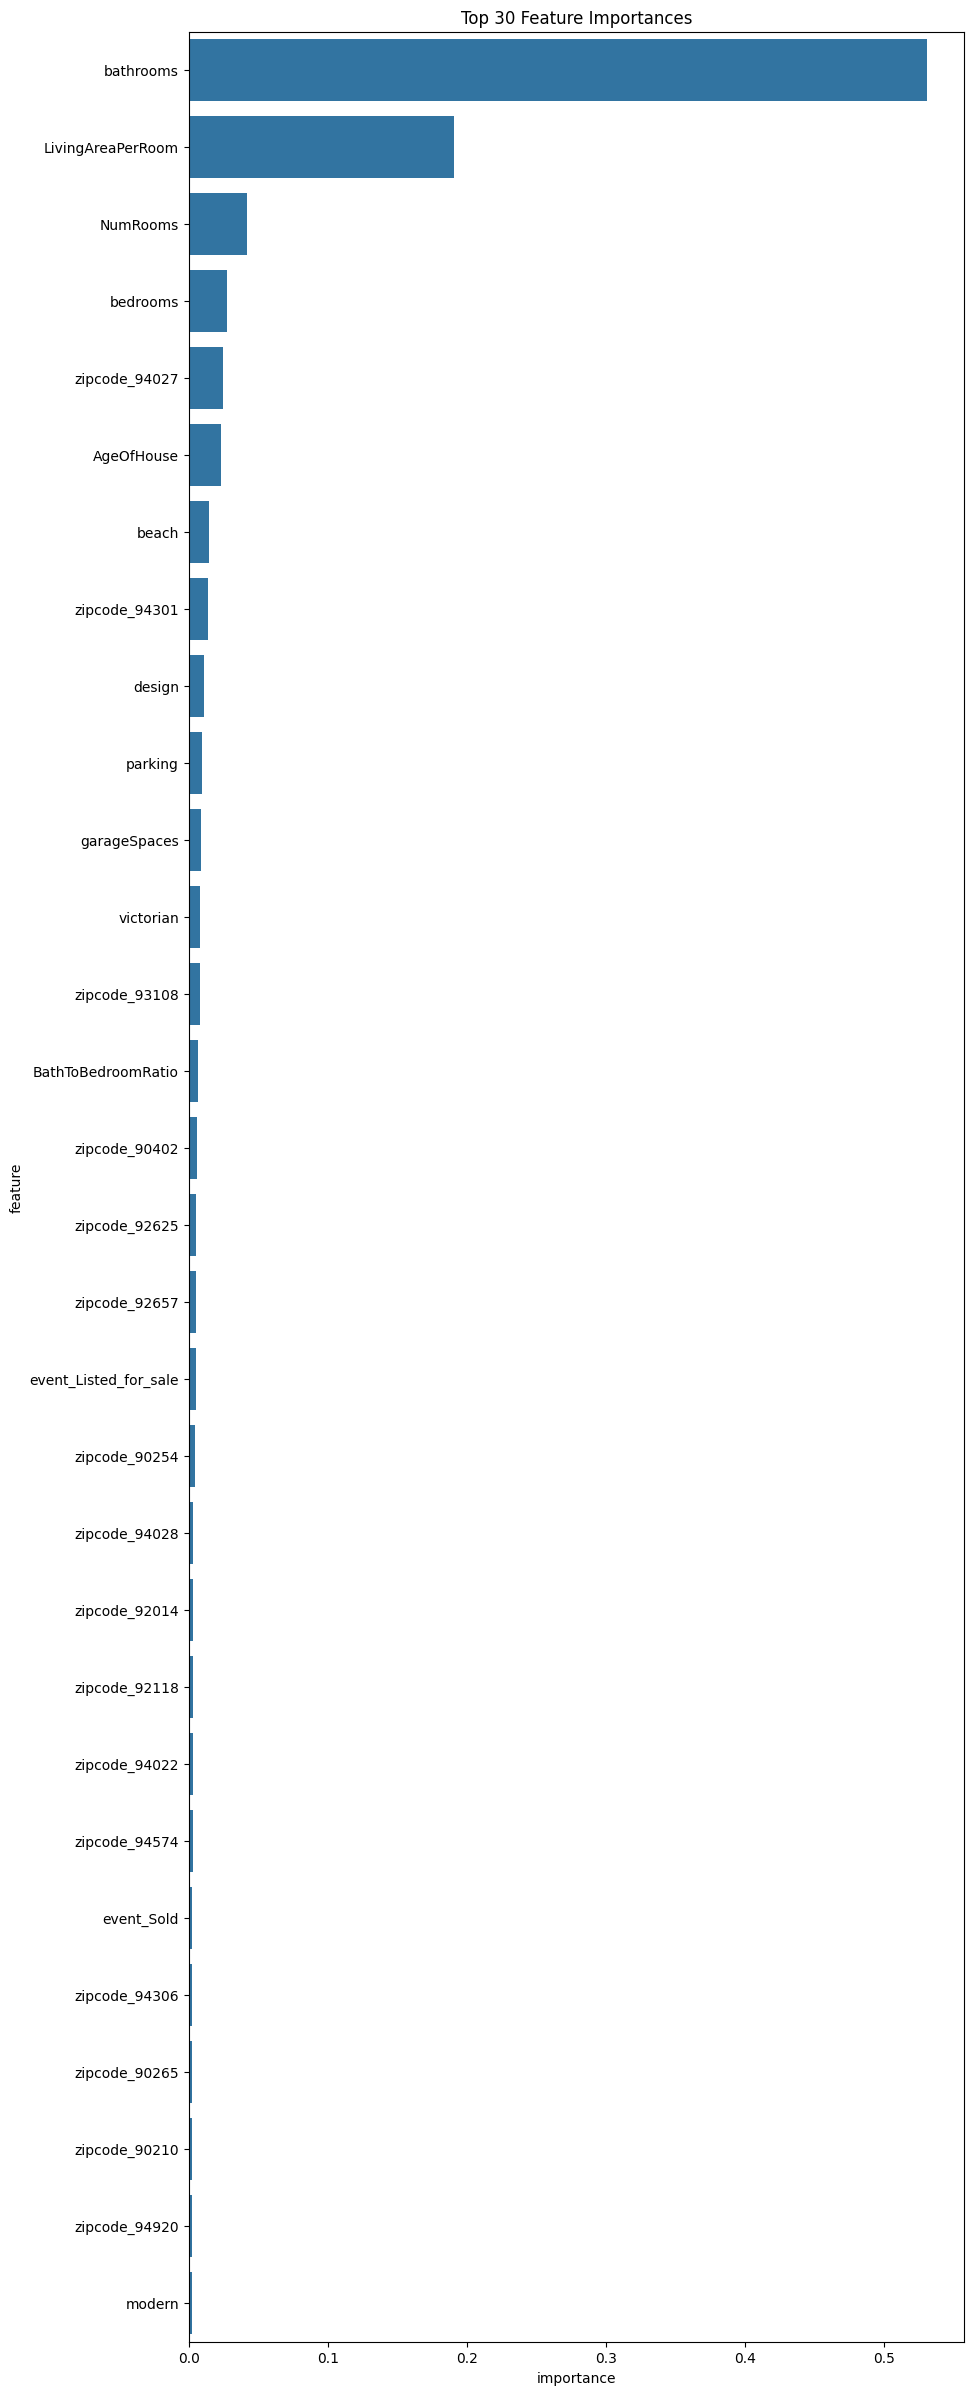

In [12]:
#Print out the n_estimators, learning_rate, max_depth and random_state of the model with respective labels
print(f"n_estimators: {grid_search_gb.n_estimators}")
print(f"learning_rate: {grid_search_gb.learning_rate}")
print(f"max_depth: {grid_search_gb.max_depth}")
print(f"random_state: {grid_search_gb.random_state}")

# Plot the feature importances
plt.figure(figsize=(10, 30))
sns.barplot(data=feature_importances.head(30), x='importance', y='feature')
plt.title("Top 30 Feature Importances")
plt.show()



In [13]:
#print the top 60 feature importances
print(feature_importances.head(30))

                    feature  importance
0                 bathrooms    0.530823
67        LivingAreaPerRoom    0.190601
66                 NumRooms    0.041782
1                  bedrooms    0.027198
876           zipcode_94027    0.024922
65               AgeOfHouse    0.023323
40                    beach    0.014779
915           zipcode_94301    0.013488
29                   design    0.010695
2                   parking    0.009503
3              garageSpaces    0.008584
46                victorian    0.008423
671           zipcode_93108    0.008220
68       BathToBedroomRatio    0.006726
169           zipcode_90402    0.005847
579           zipcode_92625    0.005407
592           zipcode_92657    0.005076
70    event_Listed_for_sale    0.004841
146           zipcode_90254    0.004314
877           zipcode_94028    0.003268
383           zipcode_92014    0.003073
432           zipcode_92118    0.002732
873           zipcode_94022    0.002694
975           zipcode_94574    0.002681


##### Analyze the distribution of keywords in the 'description' field

/var/folders/2n/0tkz0zq15yd__6fnrfptly700000gn/T/ipykernel_92532/3487366019.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keyword_counts[11:31], y=keyword_counts[11:31].index, palette='viridis')


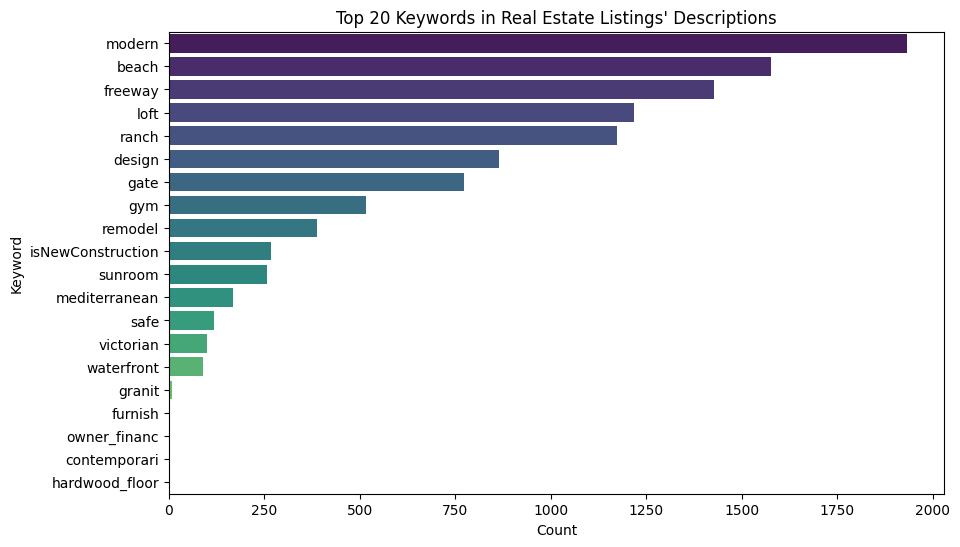

In [14]:
# Analyze the distribution of keywords
keyword_counts = df.drop('price', axis=1).sum()  # Count occurrences of each keyword
keyword_counts = keyword_counts.sort_values(ascending=False)
#Plot for the top 20 keywords excluding the first 10 which are the derived features
plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_counts[11:31], y=keyword_counts[11:31].index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Top 20 Keywords in Real Estate Listings\' Descriptions')
plt.show()



### Test out different modeling techniques and identify which one can provide the best predictions

In [26]:
import time
# Define parameter grids for different models

# n_estimators: 100
# learning_rate: 0.1
# max_depth: 3
# random_state: 42

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2]
}

param_grid_lr = {}  # No hyperparameters to tune for Linear Regression

param_grid_ridge = {
    'alpha': [0.1, 0.5],
    'random_state': [42]
}

param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0],
    'random_state': [42]
}


# Create GridSearchCV objects
grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, scoring='neg_mean_squared_error', cv=5)
grid_search_lr = GridSearchCV(LinearRegression(), param_grid_lr, scoring='neg_mean_squared_error', cv=5)
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, scoring='neg_mean_squared_error', cv=5)

In [27]:

# Fit GridSearchCV objects and record fit times
model_results = {}
for model_name, grid_search in [
    ('Gradient Boosting', grid_search_gb),
    ('Linear Regression', grid_search_lr),
    ('Ridge Regression', grid_search_ridge),
    ('Lasso Regression', grid_search_lasso)
]:
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    fit_time = end_time - start_time
    
    # Evaluate model performance
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    model_results[model_name] = (best_estimator, mse, r2, fit_time)
    print (f"Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print(f"Fit Time: {fit_time} seconds")
    print()

Model: Gradient Boosting
Best Parameters: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600, 'random_state': 42, 'subsample': 1.0, 'warm_start': True}
Mean Squared Error: 2321778209060.556
R-squared: 0.5431473426604001
Fit Time: 865.0864861011505 seconds

Model: Linear Regression
Best Parameters: {}
Mean Squared Error: 272206661541326.84
R-squared: -52.561677935212614
Fit Time: 9.883080005645752 seconds

Model: Ridge Regression
Best Parameters: {'alpha': 0.1, 'random_state': 42}
Mean Squared Error: 2583267527507.4424
R-squared: 0.49169449951966027
Fit Time: 11.902687072753906 seconds



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.102e+15, tolerance: 4.615e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.226e+15, tolerance: 5.007e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Model: Lasso Regression
Best Parameters: {'alpha': 10.0, 'random_state': 42}
Mean Squared Error: 2591073113376.624
R-squared: 0.49015860662837885
Fit Time: 462.48955607414246 seconds



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.202e+15, tolerance: 6.020e+12
  model = cd_fast.enet_coordinate_descent(


In [28]:
# Get best estimators
best_gb = grid_search_gb.best_estimator_
best_lr = grid_search_lr.best_estimator_
best_ridge = grid_search_ridge.best_estimator_
best_lasso = grid_search_lasso.best_estimator_

# Evaluate best estimators on test set
y_pred_gb = best_gb.predict(X_test)
y_pred_lr = best_lr.predict(X_test)
y_pred_ridge = best_ridge.predict(X_test)
y_pred_lasso = best_lasso.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Gradient Boosting - MSE: {mse_gb}, R-squared: {r2_gb}")
print(f"Linear Regression - MSE: {mse_lr}, R-squared: {r2_lr}")
print(f"Ridge Regression - MSE: {mse_ridge}, R-squared: {r2_ridge}")
print(f"Lasso Regression - MSE: {mse_lasso}, R-squared: {r2_lasso}")


Gradient Boosting - MSE: 2321778209060.556, R-squared: 0.5431473426604001
Linear Regression - MSE: 272206661541326.84, R-squared: -52.561677935212614
Ridge Regression - MSE: 2583267527507.4424, R-squared: 0.49169449951966027
Lasso Regression - MSE: 2591073113376.624, R-squared: 0.49015860662837885


In [29]:
# Select the best model based on evaluation metrics
models = {
    'Gradient Boosting': (best_gb, mse_gb, r2_gb),
    'Linear Regression': (best_lr, mse_lr, r2_lr),
    'Ridge Regression': (best_ridge, mse_ridge, r2_ridge),
    'Lasso Regression': (best_lasso, mse_lasso, r2_lasso)
}

# Choose the model with the highest R-squared
best_model_name = max(models, key=lambda model_name: models[model_name][2]) 
best_model = models[best_model_name][0]
best_mse = models[best_model_name][1]
best_r2 = models[best_model_name][2]

print(f"Best Model with highest R-squared: {best_model_name}")
print(f"Best Model - MSE: {best_mse}, R-squared: {best_r2}")

Best Model with highest R-squared: Gradient Boosting
Best Model - MSE: 2321778209060.556, R-squared: 0.5431473426604001


In [30]:
# OR choose the model with the lowest MSE
best_model_name = min(models, key=lambda model_name: models[model_name][1]) 
best_model = models[best_model_name][0]
best_mse = models[best_model_name][1]
best_r2 = models[best_model_name][2]

print(f"Best Model with lowest MSE: {best_model_name}")
print(f"Best Model - MSE: {best_mse}, R-squared: {best_r2}")

Best Model with lowest MSE: Gradient Boosting
Best Model - MSE: 2321778209060.556, R-squared: 0.5431473426604001


### Perform model interpretation and visualizations

               feature  importance
0            bathrooms    0.397286
67   LivingAreaPerRoom    0.117321
65          AgeOfHouse    0.051155
40               beach    0.033361
2              parking    0.031832
..                 ...         ...
630      zipcode_92841    0.000000
629      zipcode_92840    0.000000
628      zipcode_92835    0.000000
627      zipcode_92833    0.000000
760      zipcode_93514    0.000000

[1521 rows x 2 columns]


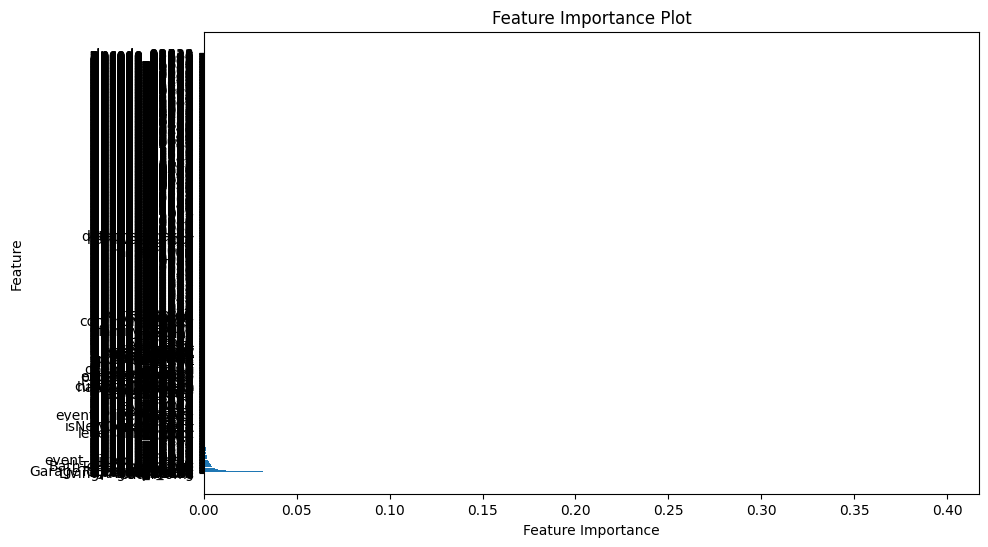

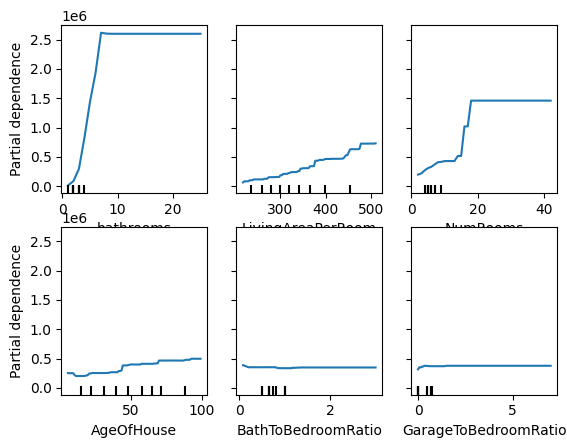

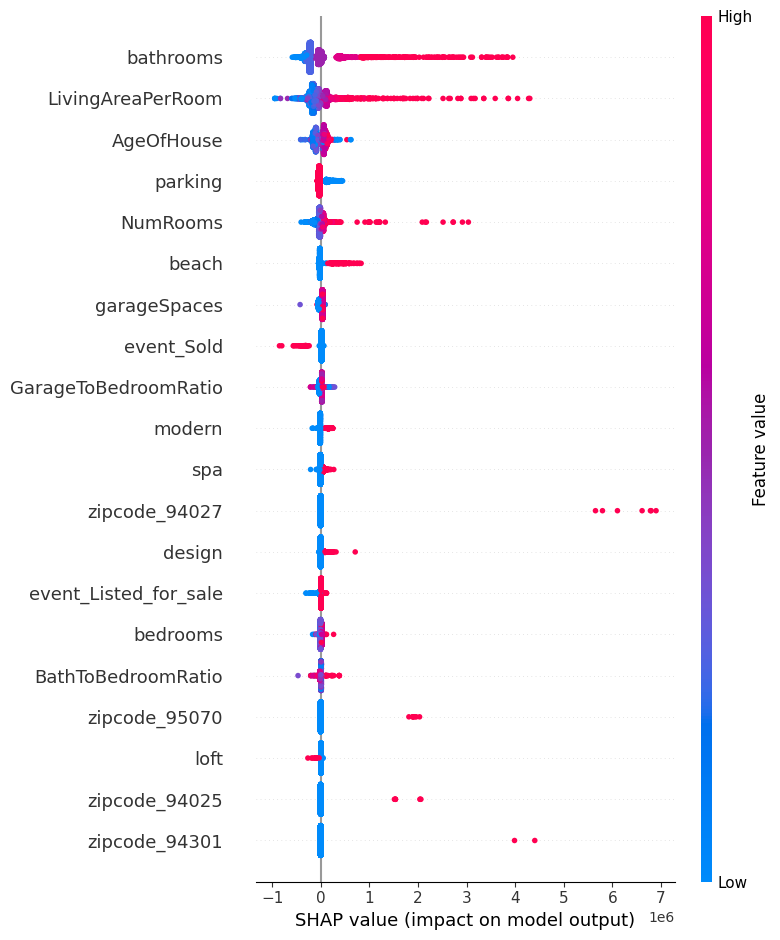

In [31]:
import matplotlib.pyplot as plt
import shap 

# Feature Importance
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
print(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

# Partial Dependence Plots
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_model, X_train, ['bathrooms', 'LivingAreaPerRoom', 'NumRooms', 'AgeOfHouse', 'BathToBedroomRatio', 'GarageToBedroomRatio']) 
plt.show()

# SHAP Values
explainer = shap.Explainer(best_model) 
shap_values = explainer(X_test)

# Force Plot
shap.plots.force(shap_values[0])  # Create a force plot for the first instance in the test set
plt.show()

# Summary Plot
shap.summary_plot(shap_values)  # Create a summary plot of SHAP values
plt.show()

#### Identify which numerical features have a linear relationship with price

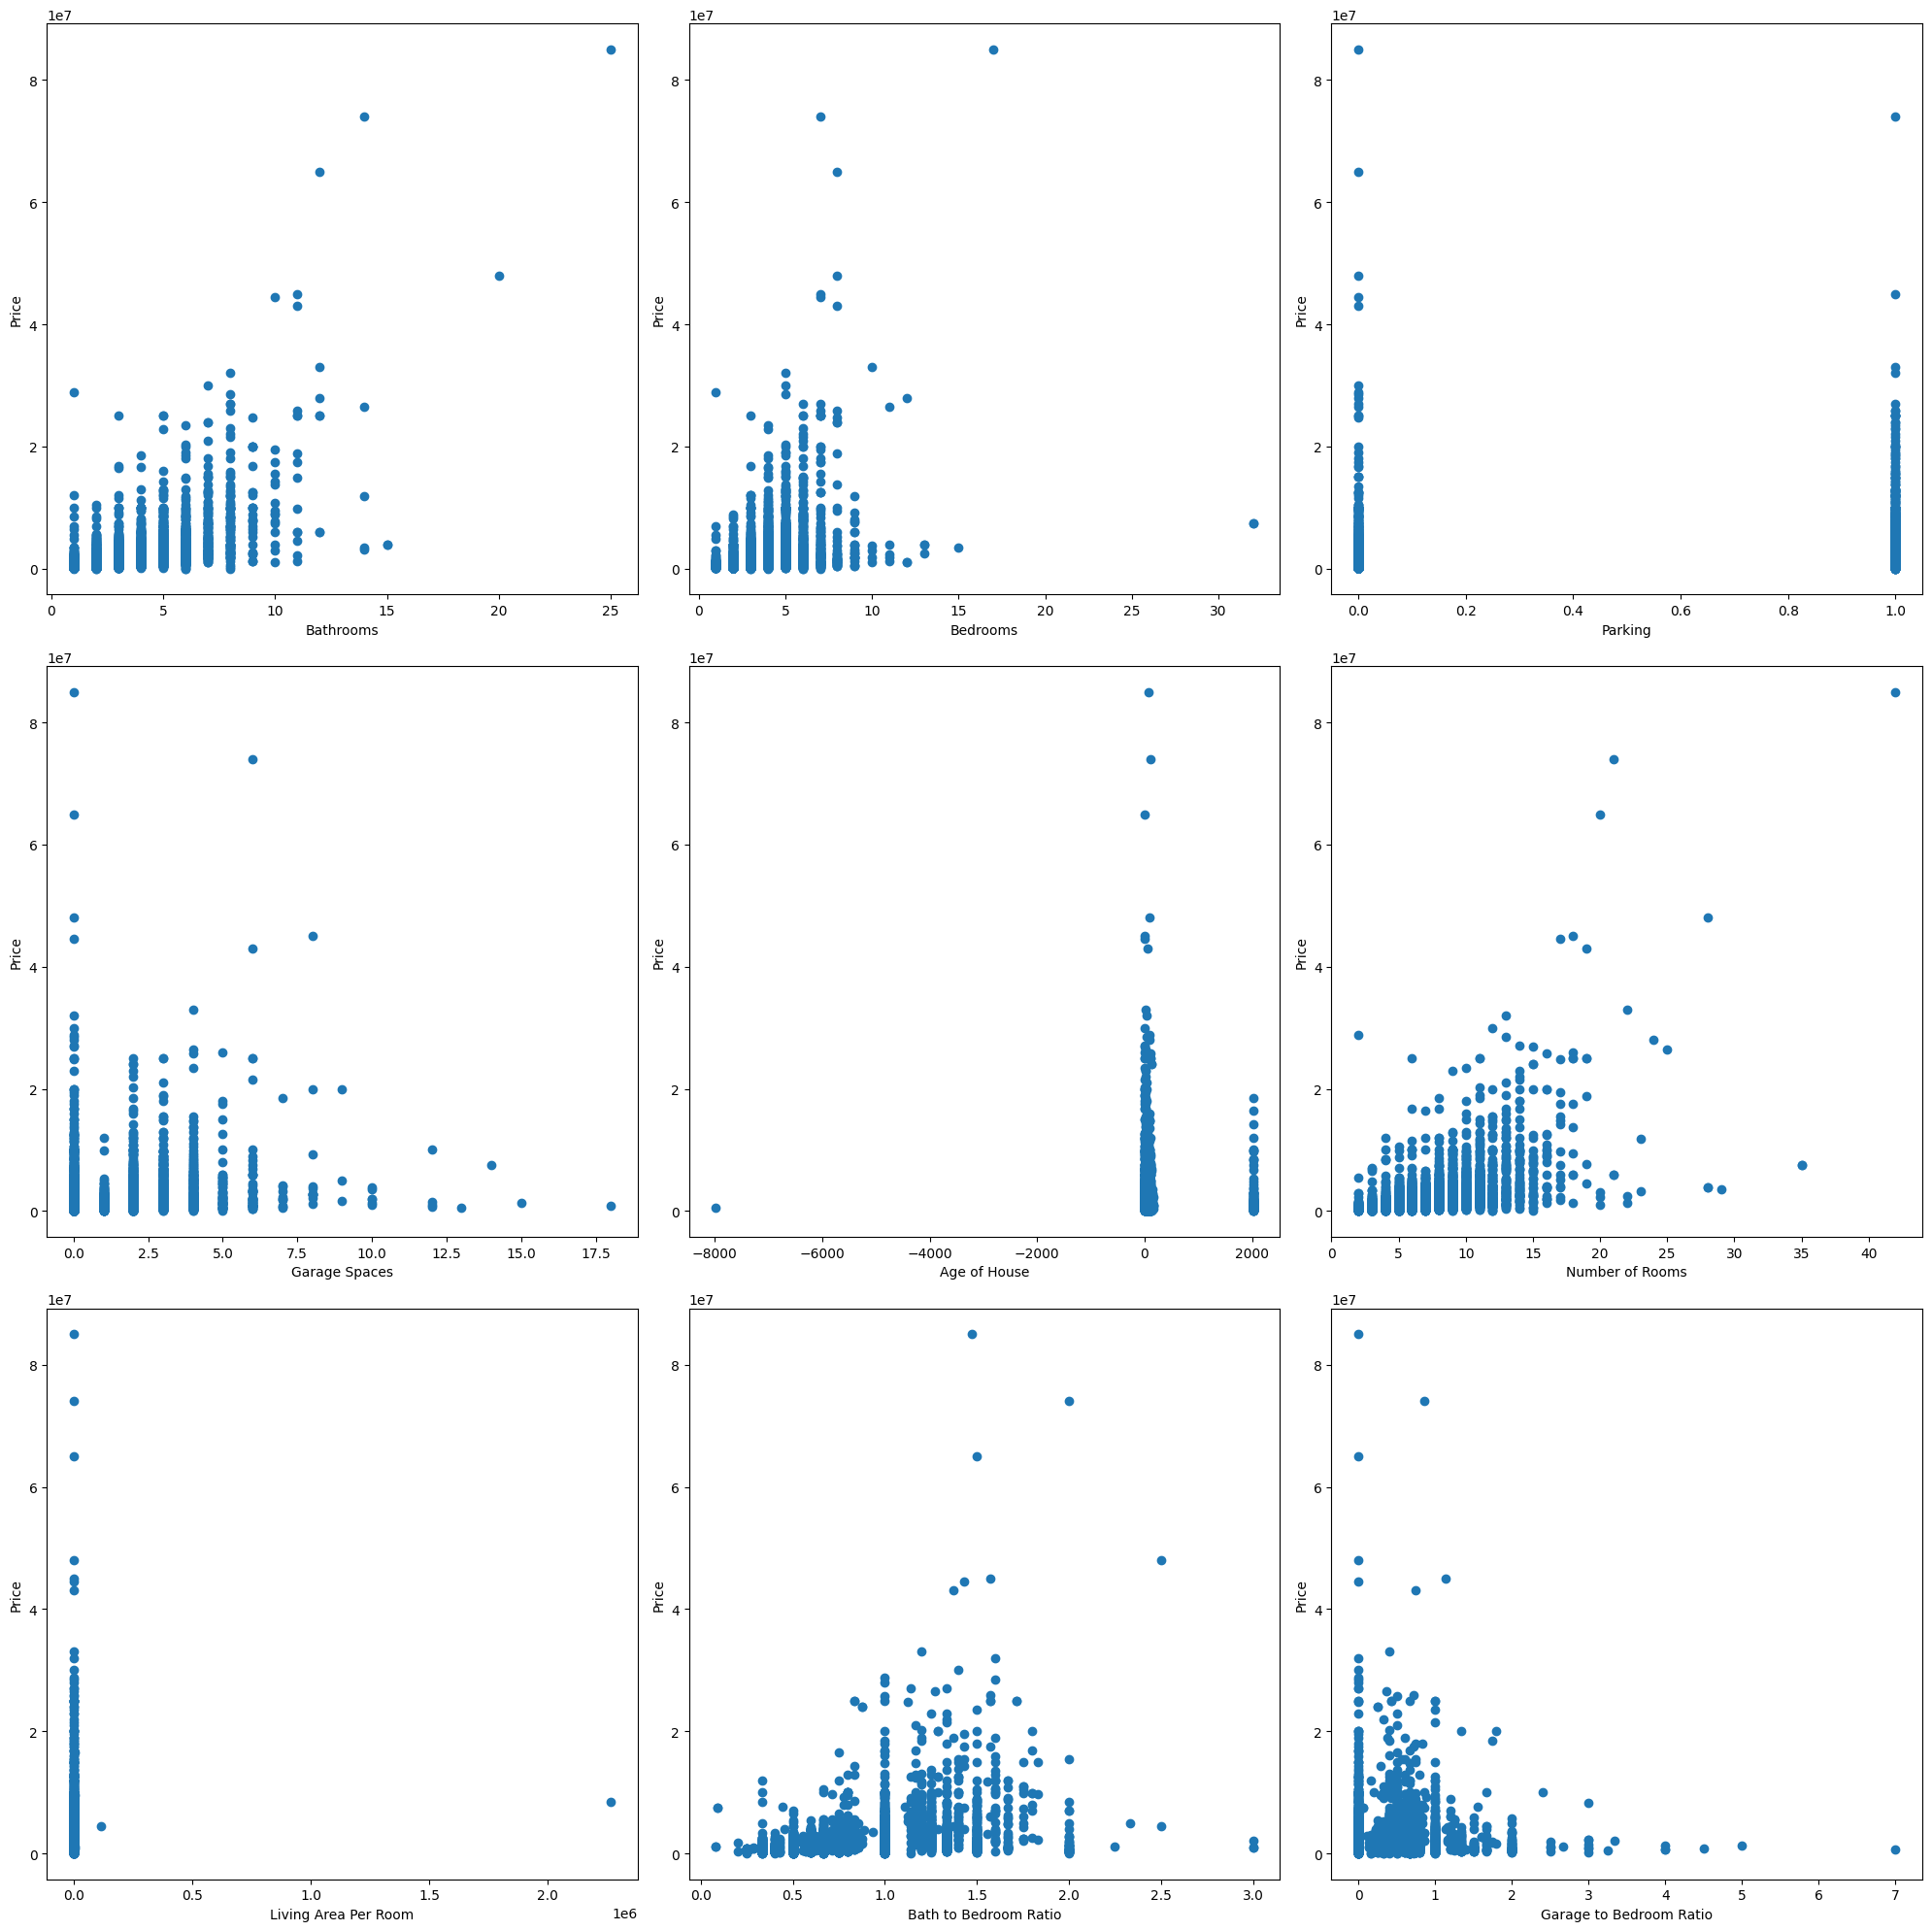

In [34]:
#Create plots that show the relationship between these features and price with the goal of understanding whether the relationship is linear or non-linear
# bathrooms
# bedrooms
# parking
# garageSpaces
# AgeOfHouse
# NumRooms
# LivingAreaPerRoom
# BathToBedroomRatio
# GarageToBedroomRatio

# Create a scatter plot for each feature
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
plt.scatter(df_ohe['bathrooms'], df_ohe['price'])
plt.xlabel('Bathrooms')
plt.ylabel('Price')

plt.subplot(3, 3, 2)
plt.scatter(df_ohe['bedrooms'], df_ohe['price'])
plt.xlabel('Bedrooms')
plt.ylabel('Price')

plt.subplot(3, 3, 3)
plt.scatter(df_ohe['parking'], df_ohe['price'])
plt.xlabel('Parking')
plt.ylabel('Price')

plt.subplot(3, 3, 4)
plt.scatter(df_ohe['garageSpaces'], df_ohe['price'])
plt.xlabel('Garage Spaces')
plt.ylabel('Price')

plt.subplot(3, 3, 5)
plt.scatter(df_ohe['AgeOfHouse'], df_ohe['price'])
plt.xlabel('Age of House')
plt.ylabel('Price')

plt.subplot(3, 3, 6)
plt.scatter(df_ohe['NumRooms'], df_ohe['price'])
plt.xlabel('Number of Rooms')
plt.ylabel('Price')

plt.subplot(3, 3, 7)
plt.scatter(df_ohe['LivingAreaPerRoom'], df_ohe['price'])
plt.xlabel('Living Area Per Room')
plt.ylabel('Price')

plt.subplot(3, 3, 8)
plt.scatter(df_ohe['BathToBedroomRatio'], df_ohe['price'])
plt.xlabel('Bath to Bedroom Ratio')
plt.ylabel('Price')

plt.subplot(3, 3, 9)
plt.scatter(df_ohe['GarageToBedroomRatio'], df_ohe['price'])
plt.xlabel('Garage to Bedroom Ratio')
plt.ylabel('Price')

plt.tight_layout()
plt.show()


In [43]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# ... (Your code to load, prepare, and split data)

# Select the features for polynomial transformation
poly_features = ['bathrooms', 'bedrooms', 'garageSpaces', 'AgeOfHouse', 'NumRooms', 'LivingAreaPerRoom', 'BathToBedroomRatio', 'GarageToBedroomRatio']

# Create the polynomial features
poly = PolynomialFeatures(degree=1, include_bias=False)  # Adjust degree as needed
poly_features_df = poly.fit_transform(df_ohe[poly_features])

# Create a DataFrame for the polynomial features
poly_features_df = pd.DataFrame(poly_features_df, columns=poly.get_feature_names_out(poly_features))

# Concatenate the polynomial features with the original DataFrame
df_poly = pd.concat([df_ohe, poly_features_df], axis=1)

# Separate features and target
X_poly = df_poly.drop('price', axis=1)
X_poly = X_poly.loc[:, ~X_poly.columns.str.startswith('description_')] # Drop the description columns
y_poly = df_poly['price']

# Split the data into training and testing sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Create GridSearchCV objects
grid_search_lr_poly = GridSearchCV(LinearRegression(), param_grid_lr, scoring='neg_mean_squared_error', cv=5)
grid_search_ridge_poly = GridSearchCV(Ridge(), param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
grid_search_lasso_poly = GridSearchCV(Lasso(), param_grid_lasso, scoring='neg_mean_squared_error', cv=5)

# Fit the models
grid_search_lr_poly.fit(X_train_scaled, y_train_poly)
grid_search_ridge_poly.fit(X_train_scaled, y_train_poly)
grid_search_lasso_poly.fit(X_train_scaled, y_train_poly)

# Make predictions and evaluate models
models = {
    'Linear Regression': (grid_search_lr_poly, X_test_scaled, y_test_poly),
    'Ridge Regression': (grid_search_ridge_poly, X_test_scaled, y_test_poly),
    'Lasso Regression': (grid_search_lasso_poly, X_test_scaled, y_test_poly)
}

for model_name, (grid_search, X_test, y_test) in models.items():
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print("-" * 20)

# ... (rest of the code for feature importance)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e+15, tolerance: 4.615e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e+15, tolerance: 5.007e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Model: Linear Regression
Mean Squared Error: 6.5944282535577254e+35
R-squared: -1.2975753065113756e+23
--------------------
Model: Ridge Regression
Mean Squared Error: 2593400447890.933
R-squared: 0.4897006606655685
--------------------
Model: Lasso Regression
Mean Squared Error: 2593931454823.4995
R-squared: 0.4895961752641369
--------------------


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e+15, tolerance: 6.020e+12
  model = cd_fast.enet_coordinate_descent(


#### Using polynomial degrees
##### Using degree=5, led to these results:
<pre>
- Model: Linear Regression
Mean Squared Error: 4.800549035697296e+34
R-squared: -9.445965058543465e+21
--------------------
- Model: Ridge Regression
Mean Squared Error: 9286080846188.072
R-squared: -0.8272075662937419
--------------------
- Model: Lasso Regression
Mean Squared Error: 7996595115494.11
R-squared: -0.5734774811503391
</pre>

##### Clearly a high degree of polynomail is not helping. So I reduced it to degree=1 and achieved these results:
<pre>
Model: Linear Regression
Mean Squared Error: 6.5944282535577254e+35
R-squared:    75753065113756e+23
--------------------
Model: Ridge Regression
Mean Squared Error: 2593400447890.933
R-squared: 0.4897006606655685
--------------------
Model: Lasso Regression
Mean Squared Error: 2593931454823.4995
R-squared: 0.4895961752641369
--------------------
</pre>

## Models comparison:

- **Linear Regression:**
The negative R-squared values and the large MSEs for Linear Regression are a strong indication that there might be high collinearity in the dataset. 

- **Ridge Regression:**
The R-squared is 0.49. Not a strong R-squared metric. Also the MSE is quite high (2593400447890). So this model may not be the best fit.

- **Lasso Regression:**
The R-squared is also similar to Ridge Regression: 0.49. Again, not a strong R-squared metric. Also the MSE is quite high (2593931454823). So this model may not be the best fit either.

- **Gradient Boosting:**
The default model settings provided these metrics:
  - **Mean Squared Error:** 1677991963670.7976 
  - **R-squared:** 0.67 <p>

| Model             | MSE                | R-squared |
|-------------------|--------------------|-----------|
| Linear Regression | 6.59442825355e+35  | Negative  |
| Ridge Regression  | 2593400447890      | 0.49      |
| Lasso Regression  | 2593931454823      | 0.49      |
| Gradient Boosting | 1677991963670      | 0.67      |

  The R-squared is much better than the Ridge or Lasso Regressions and also the MSE is relatively much smaller (1677991963670 vs. 2593400447890).<p>
  Hyper parameter tuning for Gradient Boosting did not result in better results. So default model works best.

### Gradient Boosting is the best predictor model

## Feature Importance Analysis: Gradient Boosting Results
I have trained a Gradient Boosting model to predict house prices using a variety of features, including some derived features and one-hot encoded zip code data. The results are quite revealing:

#### Key Findings:
1. **Bathrooms Reign Supreme**: The most important feature by far is the number of bathrooms. This reinforces the well-known fact that more bathrooms are strongly associated with higher house prices.
2. **Space is Key**: The feature LivingAreaPerRoom, representing living area per room, has a significant importance score. It suggests that buyers value houses with ample space per room.
3. **Other Notable Factors**: NumRooms (total rooms) has a smaller but still noticeable importance. Interestingly, AgeOfHouse also has a relatively high importance, suggesting that older houses might be less desirable.
4. **Location is Crucial**: We see some zip codes with significant importance scores, such as zipcode_94301.0, zipcode_94027.0, and zipcode_92118.0. These zip codes likely represent areas with high demand, desirable amenities, or other factors driving up prices.
5. **Gold nuggets in the 'description' field**: Its interesting to note that proximity to beach and architectural styles (like the Victorian) play a significant factor too.

#### Interpreting the Results:
- The high importance scores for bathrooms, LivingAreaPerRoom, and Rooms are intuitive and align with common real estate knowledge.
- The significant influence of some zip codes highlights the importance of location and neighborhood factors.

#### Here are the top features with their importance scores:
<pre>
            feature  importance
         bathrooms    0.530823
 LivingAreaPerRoom    0.190601
          NumRooms    0.041782
          bedrooms    0.027198
     zipcode_94027    0.024922
        AgeOfHouse    0.023323
             beach    0.014779
     zipcode_94301    0.013488
            design    0.010695
           parking    0.009503
      garageSpaces    0.008584
         victorian    0.008423
     zipcode_93108    0.008220
BathToBedroomRatio    0.006726
     zipcode_90402    0.005847
</pre>

#### Next Steps:
- **Deep Dive on Key Features**: We should delve deeper into the factors that make specific zip codes more desirable. This could involve analyzing demographic data, crime rates, school quality, proximity to amenities, and other relevant factors.
- **Domain Expertise**: Consider seeking input from real estate experts to validate our findings and understand the local market dynamics.
- **Model Refinement**: We can continue to refine our model by incorporating other potentially influential features, like the Distance to Amenities, Property Tax Rate, or any other relevant factors.

Overall, the feature importance analysis provides valuable insights into the factors driving house prices. By focusing on these key features and exploring the nuances of location, we can enhance our ability to predict house prices accurately.

It's important to remember that these findings are based on the data and model used, and they might vary depending on the dataset and the model's parameters.